# TensoRF Color Variance

## Imports

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from tensorf_testing_suite.tensorf_models.tensoRF import TensorVMSplit
from tensorf_testing_suite.dataLoader.your_own_data import YourOwnDataset

/Users/alexanderkorte/miniforge3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(20211202)
np.random.seed(20211202)

## Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load('trained_models/tensorf_small_baseline.th', map_location=device)
kwargs = ckpt['kwargs']
kwargs.update({'device': device})
tensorf = TensorVMSplit(**kwargs)
tensorf.load(ckpt)

aabb tensor([-1.5000, -1.5000, -1.5000,  0.7913,  1.5000,  0.1299])
grid size [307, 402, 218]
sampling step size:  tensor(0.0037)
sampling number:  1098
pos_pe 6 view_pe 2 fea_pe 2
MLPRender_Fea(
  (mlp): Sequential(
    (0): Linear(in_features=150, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [11]:
dataset = YourOwnDataset('./datasets/small_baseline/', split='test', is_stack=True)

Loading data test (81): 100%|██████████| 81/81 [00:00<00:00, 125.23it/s]


## Find Color Variance

In [24]:
ray = dataset[0]['rays'][0].to(device).view(-1, 6).to(device)
print(ray)

with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(ray)

rgb_map, depth, rgb, sigma, xyz_sampled = output

rgb = rgb[0].cpu().numpy()
sigma = sigma[0].cpu().numpy()
xyz_sampled = xyz_sampled[0].cpu().numpy()


tensor([[ 0.0175, -0.0175,  0.0000, -0.2166,  0.9418, -0.2570]])


## Graphical Data Views

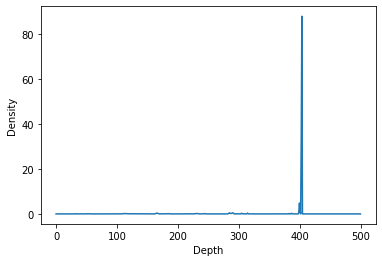

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

ax.plot(sigma[:500])

plt.show()

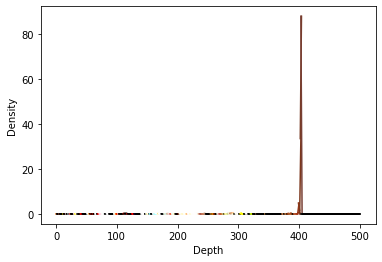

In [26]:
fig_col = plt.figure()
ax = fig_col.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

# ax.set_ylim(0, 1)
for i in range(len(sigma[:500])):
    ax.plot([i,i+2],sigma[i:i+2],color=(tuple(rgb[i])))

plt.show()

In [27]:
for i, val in enumerate(sigma):
    if val > 60:
        print(i)

403


In [29]:
variance_depth = 403
xyz = xyz_sampled[variance_depth]
xyz = torch.tensor(xyz).to(device).view(1,3)

sampled_ray = ray[0].cpu().numpy()
testing_views = []
size = 90
for i in range(size**2):
    testing_views.append([(((i%size)-45)/360)+sampled_ray[3], ((int(i/size)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_views = torch.tensor(testing_views, dtype=torch.float32).to(device)

variance_map = []
with torch.no_grad():
    tensorf.eval()
    for view in testing_views:
        testing_view = torch.tensor(view).to(device).view(1,3)
        variance_map.append(tensorf.get_variance(xyz, testing_view)[0].cpu().numpy())
    variance_map = np.array(variance_map)

/var/folders/pj/pdfdfscs3hjg6dyzhnb84n_80000gn/T/ipykernel_45731/808272790.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_view = torch.tensor(view).to(device).view(1,3)


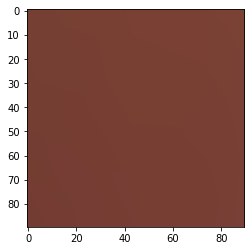

In [30]:
variance_map = variance_map.reshape(size,size,3)
imgplot = plt.imshow(variance_map)

In [15]:
from IPython.display import display, HTML

rays0 = np.load('sbrays.npy')
df = pd.DataFrame(rays0)
display(df)
print(rays0[0][0] - rays0[1][0])
print(rays0[1][0] - rays0[2][0])

,0,1,2,3,4,5
0,0.008750,-0.008750,0.0,0.060434,-0.964156,-0.258360
1,-0.008750,-0.017500,0.0,-0.050247,-0.936729,-0.346432
2,0.017500,0.013125,0.0,0.244152,0.211362,-0.946423
3,-0.013125,0.017500,0.0,-0.387214,-0.577960,-0.718350
4,0.008750,0.000000,0.0,-0.135306,0.941825,-0.307665
...,...,...,...,...,...,...
4091,0.013125,0.017500,0.0,-0.010831,-0.980224,-0.197593
4092,0.004375,-0.008750,0.0,0.151690,0.608866,-0.778635
4093,0.008750,0.008750,0.0,0.086188,-0.915157,-0.393775
4094,0.004375,0.000000,0.0,0.118843,0.894704,-0.430559


0.0175
-0.026250001


In [14]:
testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([1.5-j/size*2, 1.5-i/size*2, -1.7500, -0.5, -0.5,  2.0000])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:01<00:00, 32.94it/s]


In [23]:
aabb = [-0.6732, -1.1929, -0.4843,  0.6732,  1.1929,  1.0512]

testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([2-j/size, -1, 3-i/size*2, -0.5, 0.5, -0.5])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:00<00:00, 78.72it/s] 


In [5]:
ray = torch.tensor([[ 0,  0, 0, -0.5, 1, -0.75]]).to(device) # x,y,z, dx,dy,dz

testing_rays = []
size = 64 #1024
for i in range(size):
    for j in range(size):
        # testing_rays.append([0.0175, 0, 0, -0.125, 1-i/size*2, 1-j/size*2])
        testing_rays.append([0.0175, 0, 0, -0.125, 1-i/size*2, 1-j/size*2])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

Loading data test (81): 100%|██████████| 81/81 [00:00<00:00, 149.83it/s]


160000

In [9]:

testing_rays = dataset[0]['rays']
size = math.sqrt(len(testing_rays))
size = int(size) if size.is_integer() else print("NOT SQUARE TESTING PHOTO")

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

Loading data test (81): 100%|██████████| 81/81 [00:00<00:00, 133.90it/s]
/var/folders/pj/pdfdfscs3hjg6dyzhnb84n_80000gn/T/ipykernel_45731/2699883415.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
100%|██████████| 40/40 [01:48<00:00,  2.71s/it]


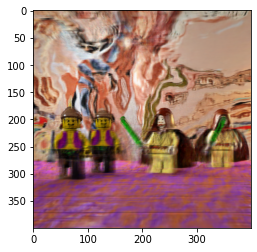

In [10]:
rgb_map = np.array(output)
rgb_map = rgb_map.reshape(size,size,3)
imgplot = plt.imshow(rgb_map)

In [21]:
img = Image.fromarray((rgb_map*255).astype(np.uint8))
img.save("trex.png")